In [57]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [58]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 hours 50 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_ccastrob_cocs40
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.340 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [59]:
madrid = pd.read_csv("../data/clean-madrid-v2.csv")

#### Due to correlation we have to eliminate "sq_mt_useful" column and "has_garden" has problems when we are importing it as CSV.

#### I will remove some other columns that won't be used to predict:

In [60]:
madrid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9130 non-null   int64  
 1   sq_mt_built         9130 non-null   float64
 2   sq_mt_useful        9130 non-null   float64
 3   n_rooms             9130 non-null   int64  
 4   n_bathrooms         9130 non-null   int64  
 5   latitude            9130 non-null   float64
 6   longitude           9130 non-null   float64
 7   raw_address         9130 non-null   object 
 8   neighborhood_id     9130 non-null   object 
 9   buy_price           9130 non-null   int64  
 10  is_new_development  9130 non-null   int64  
 11  is_renewal_needed   9130 non-null   int64  
 12  has_lift            9130 non-null   int64  
 13  is_exterior         9130 non-null   int64  
 14  has_parking         9130 non-null   int64  
 15  floor               9130 non-null   float64
 16  house_

In [61]:
columns_to_drop = [#"has_garden", 
                   "sq_mt_useful",
                    "id", 
                   # "title", 
                   # "subtitle", 
                   "raw_address", 
                   "neighborhood_id"]

In [62]:
madrid.drop(columns_to_drop, axis=1, inplace=True)

<AxesSubplot:>

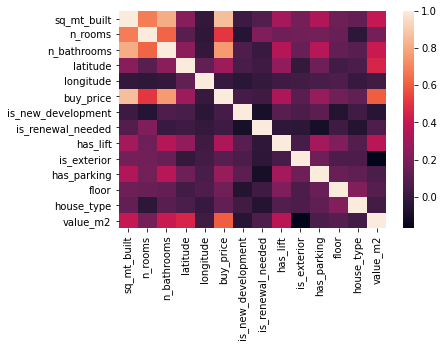

In [63]:
sns.heatmap(madrid.corr())

In [10]:
y = madrid.buy_price

In [11]:
X = madrid.drop("buy_price", axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### H2O train:

In [64]:
h2o_df = h2o.H2OFrame(madrid)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8])

In [66]:
train_h2o.shape

(7390, 16)

In [67]:
test_h2o.shape

(1740, 16)

In [68]:
y_cols = "buy_price"

In [69]:
X_cols = train_h2o.drop("buy_price", axis=1).columns

In [70]:
automl = H2OAutoML(max_models=250, max_runtime_secs=6000)
automl.train(x=X_cols, y=y_cols, training_frame=train_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [71]:
lb = automl.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210726_135529,1.66121e+10,128888,1.66121e+10,62686.1,0.173482
StackedEnsemble_BestOfFamily_AutoML_20210726_135529,1.73717e+10,131802,1.73717e+10,64865.1,0.17757
GBM_grid__1_AutoML_20210726_135529_model_35,1.89617e+10,137702,1.89617e+10,67636.6,0.185669
GBM_grid__1_AutoML_20210726_135529_model_59,1.92246e+10,138653,1.92246e+10,65721.3,0.183679
GBM_grid__1_AutoML_20210726_135529_model_12,1.92473e+10,138735,1.92473e+10,65434.1,0.1835
XGBoost_grid__1_AutoML_20210726_135529_model_73,1.92803e+10,138853,1.92803e+10,68228.9,0.189829
XGBoost_grid__1_AutoML_20210726_135529_model_48,1.95569e+10,139846,1.95569e+10,68109.5,0.187788
GBM_grid__1_AutoML_20210726_135529_model_6,1.96385e+10,140137,1.96385e+10,68463.2,0.187015
GBM_grid__1_AutoML_20210726_135529_model_39,1.97012e+10,140361,1.97012e+10,65578.7,0.182413
GBM_grid__1_AutoML_20210726_135529_model_9,1.97908e+10,140680,1.97908e+10,68170,0.188095


In [19]:
predictions = automl.leader.predict(test_h2o)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [20]:
predictions.shape

(1689, 1)

In [21]:
test_h2o["prediction"] = predictions

In [22]:
test_df = test_h2o.as_data_frame()

In [ ]:
test_df.a

In [23]:
cols = ["buy_price", "prediction"]

In [24]:
type(test_df)

pandas.core.frame.DataFrame

In [49]:
test_h2o.columns

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'latitude',
 'longitude',
 'rent_price',
 'buy_price',
 'is_new_development',
 'is_renewal_needed',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'has_parking',
 'has_pool',
 'has_terrace',
 'has_balcony',
 'has_storage_room',
 'floor',
 'house_type',
 'value_m2',
 'neighborhood',
 'district',
 'prediction']

#### Let's see all the models, not only the leaderboard:

In [72]:
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210726_135529,1.66121e+10,128888,1.66121e+10,62686.1,0.173482
StackedEnsemble_BestOfFamily_AutoML_20210726_135529,1.73717e+10,131802,1.73717e+10,64865.1,0.17757
GBM_grid__1_AutoML_20210726_135529_model_35,1.89617e+10,137702,1.89617e+10,67636.6,0.185669
GBM_grid__1_AutoML_20210726_135529_model_59,1.92246e+10,138653,1.92246e+10,65721.3,0.183679
GBM_grid__1_AutoML_20210726_135529_model_12,1.92473e+10,138735,1.92473e+10,65434.1,0.1835
XGBoost_grid__1_AutoML_20210726_135529_model_73,1.92803e+10,138853,1.92803e+10,68228.9,0.189829
XGBoost_grid__1_AutoML_20210726_135529_model_48,1.95569e+10,139846,1.95569e+10,68109.5,0.187788
GBM_grid__1_AutoML_20210726_135529_model_6,1.96385e+10,140137,1.96385e+10,68463.2,0.187015
GBM_grid__1_AutoML_20210726_135529_model_39,1.97012e+10,140361,1.97012e+10,65578.7,0.182413
GBM_grid__1_AutoML_20210726_135529_model_9,1.97908e+10,140680,1.97908e+10,68170,0.188095


#### Checking model error manually:

In [76]:
test_df[cols].sample(30)

,buy_price,prediction
1475,335000,3.156428e+05
1428,539000,5.376095e+05
1610,515000,5.180107e+05
1358,115000,1.238850e+05
370,425000,4.215776e+05
1272,240000,2.439865e+05
457,110000,1.178841e+05
1178,625000,6.340967e+05
876,995000,1.021426e+06
1397,373000,3.779197e+05


#### It's seems good enough for now, with some more time it can get a better model.

#### Exporting model with h2o:

In [73]:
model_path = h2o.save_model(model=automl.leader, path="../models", force=True)

In [74]:
print(model_path)

/mnt/c/Users/chris/ironhack_labs/Weekend-projects/tu_pisito/models/StackedEnsemble_AllModels_AutoML_20210726_135529
